In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-collegemsg/CollegeMsg.txt
/kaggle/input/ml-taobao2/ml_taobao.txt
/kaggle/input/ml-mooc/ml_mooc.txt
/kaggle/input/ml-enron/ml_enron.txt


In [2]:
import random
import networkx as nx
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , roc_auc_score, roc_curve
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization,Bidirectional, Dropout, Activation,SimpleRNN ,LSTM , TimeDistributed,Input, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add
from keras.optimizers import Adam,SGD
from keras.optimizers import AdamW
from keras.layers import LeakyReLU
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, optimizers, activations
from node2vec import Node2Vec
from sklearn.metrics import average_precision_score

2024-11-21 12:48:50.575835: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-21 12:48:50.576005: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 12:48:50.746399: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [1]:
!pip install node2vec

In [3]:
class TemporalRandomWalkSampler:
    def __init__(self, filename=None, num_walks=3, alpha=0.5):
        self.num_walks = num_walks
        self.alpha = alpha
        if filename:
            self.temporal_network = self.load_temporal_network(filename)
        else:
            self.temporal_network = nx.Graph()

    def load_temporal_network(self, filename):
        temporal_network = nx.Graph()
        with open(filename, 'r') as file:
            next(file)  # Skip header if there is one
            for line in file:
                parts = line.strip().split(' ')
                if len(parts) == 3:
                    source, target, timestamp = parts
                    temporal_network.add_edge(source, target, time=int(timestamp))
                else:
                    print(f"Skipping invalid line: {line.strip()}")
        return temporal_network

    def sample_temporal_random_walks(self):
        node_sets = {}
        for node in self.temporal_network.nodes():
            walks = self._sample_trws(node)
            node_sets[node] = walks
        return node_sets

    def _sample_trws(self, start_node):
        walks = []
        for _ in range(self.num_walks):
            walk = self.temporal_walk(self.temporal_network, start_node)
            walks.append(walk)
        return walks

    def temporal_walk(self, G, start_node, L=7):
        current_node = start_node
        walk = [current_node]
        current_time = 0

        for _ in range(1, L + 1):
            neighbors = [(neighbor, G.edges[current_node, neighbor]['time']) for neighbor in G.neighbors(current_node)]
            valid_edges = [(neighbor, time) for neighbor, time in neighbors if time > current_time]

            if valid_edges:
                next_node, interaction_time = self.biased_edge_selection(valid_edges, current_time)
                walk.append(interaction_time)
                walk.append(next_node)
                current_node = next_node
                current_time = interaction_time
            else:
                break

        return walk

    def biased_edge_selection(self, valid_edges, current_time):
        weights = [np.exp(-self.alpha * (edge[1] - current_time)) for edge in valid_edges]
        sum_weights = np.sum(weights)

        if sum_weights == 0 or np.isnan(sum_weights):
            # Handle the case when all weights are zero or NaN
            return random.choice(valid_edges)
        else:
            normalized_weights = weights / sum_weights
            selected_index = np.random.choice(len(valid_edges), p=normalized_weights)
            return valid_edges[selected_index]


In [4]:
def extract_temporal_motifs(walks, motif_sizes):
    motifs = {}
    for size in motif_sizes:
        size_motifs = set()
        for walk in walks:
            for i in range(0, len(walk) - size * 2 + 1, 2):
                motif = tuple(walk[i:i + size * 2:2])
                size_motifs.add(motif)
        motifs[size] = size_motifs
    return motifs

from scipy.sparse import lil_matrix, csr_matrix

def create_incidence_matrices_sparse(motifs):
    incidence_matrices = {}
    for size, size_motifs in motifs.items():
        vertices = set()
        hyperedges = []

        for motif in size_motifs:
            vertices.update(motif)
            hyperedges.append(motif)

        vertices = sorted(vertices)
        num_vertices = len(vertices)
        num_hyperedges = len(hyperedges)

        # Use sparse matrices
        incidence_matrix = lil_matrix((num_vertices, num_hyperedges))
        for j, hyperedge in enumerate(hyperedges):
            for vertex in hyperedge:
                i = vertices.index(vertex)
                incidence_matrix[i, j] = 1

        incidence_matrices[size] = (csr_matrix(incidence_matrix), vertices, hyperedges)
    return incidence_matrices

def extract_node_features(temporal_network, incidence_matrices):
    node_features = {}

    for size, (incidence_matrix, vertices, hyperedges) in incidence_matrices.items():
        # Extract features from the incidence matrix for each node
        node_degree = incidence_matrix.sum(axis=1)  # Degree centrality
        node_closeness = np.reciprocal(incidence_matrix.sum(axis=1))  # Closeness centrality
        node_betweenness = np.sum(incidence_matrix, axis=1)  # Betweenness centrality

        # Combine the features into a feature matrix
        features = np.column_stack((node_degree, node_closeness, node_betweenness))

        # Store the features in a dictionary with node labels as keys
        node_features[size] = {node: feature for node, feature in zip(vertices, features)}

    # Extract Node2Vec embeddings
    node2vec = Node2Vec(temporal_network, dimensions=64, walk_length=30, num_walks=200, workers=4)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    node2vec_features = {str(node): model.wv[str(node)] for node in temporal_network.nodes()}

    # Merge all features
    merged_features = {}
    for node in temporal_network.nodes():
        embedding_features = node2vec_features[str(node)]
        if node in node_features:
            basic_features = np.concatenate([features[node] for size, features in node_features.items() if node in features])
            merged_features[node] = np.concatenate((basic_features, embedding_features))
        else:
            merged_features[node] = embedding_features

    return merged_features

In [6]:
def prepare_link_prediction_data(temporal_network, node_features, train_size=0.7, val_size=0.15):
    positive_samples = []
    negative_samples = []

    nodes = list(temporal_network.nodes())

    # Create positive samples
    for edge in temporal_network.edges():
        source, target = edge
        if source in node_features and target in node_features:
            positive_samples.append((source, target, node_features[source], node_features[target], 1))

    # Create negative samples
    while len(negative_samples) < len(positive_samples):
        source, target = random.sample(nodes, 2)
        if not temporal_network.has_edge(source, target):
            if source in node_features and target in node_features:
                negative_samples.append((source, target, node_features[source], node_features[target], 0))

    samples = positive_samples + negative_samples
    random.shuffle(samples)

    # Check for inconsistent feature lengths
    max_len = max(len(s[2]) for s in samples)
    print(f"Maximum feature length: {max_len}")
    for s in samples:
        print(f"Feature lengths: {len(s[2])}, {len(s[3])}")

    # Pad or trim features to ensure uniform length
    X = np.array([np.concatenate((pad_or_trim(s[2], max_len), pad_or_trim(s[3], max_len))) for s in samples])
    y = np.array([s[4] for s in samples])
    edge_info = [(s[0], s[1]) for s in samples]

    # Normalize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split data into training, validation, and testing sets using StratifiedShuffleSplit
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=(1 - train_size), random_state=42)

    for train_index, temp_index in stratified_split.split(X, y):
        X_train, X_temp = X[train_index], X[temp_index]
        y_train, y_temp = y[train_index], y[temp_index]
        edge_info_train, edge_info_temp = [edge_info[i] for i in train_index], [edge_info[i] for i in temp_index]

    print("Train, Validation, and Test splits created.")

    # Further split the temp data into validation and test sets
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=(val_size / (1 - train_size)), random_state=42)

    for val_index, test_index in stratified_split.split(X_temp, y_temp):
        X_val, X_test = X_temp[val_index], X_temp[test_index]
        y_val, y_test = y_temp[val_index], y_temp[test_index]
        edge_info_val, edge_info_test = [edge_info_temp[i] for i in val_index], [edge_info_temp[i] for i in test_index]

    print("Data preparation complete.")
    return X_train, X_val, X_test, y_train, y_val, y_test, edge_info_train, edge_info_val, edge_info_test


In [5]:
def pad_or_trim(array, length):
    if len(array) < length:
        return np.pad(array, (0, length - len(array)), 'constant')
    else:
        return array[:length]

In [6]:
# Example usage (same as provided above)
filename = '/kaggle/input/ml-mooc/ml_mooc.txt'  # Replace with your actual file path
temporal_rw_sampler = TemporalRandomWalkSampler(filename, num_walks=30, alpha=0.5)

In [7]:
# Sample temporal random walks for each node in the graph
node_sets = temporal_rw_sampler.sample_temporal_random_walks()

# Extract temporal motifs from the sampled walks
all_walks = [walk for walks in node_sets.values() for walk in walks]
motif_sizes = [3, 4, 5, 6]
extracted_motifs = extract_temporal_motifs(all_walks, motif_sizes)

In [8]:
# Create incidence matrices for each n-node motif type
incidence_matrices = create_incidence_matrices_sparse(extracted_motifs)

In [9]:
incidence_matrices

{3: (<7144x367507 sparse matrix of type '<class 'numpy.float64'>'
  	with 1102521 stored elements in Compressed Sparse Row format>,
  ['1',
   '10',
   '100',
   '1000',
   '1001',
   '1002',
   '1003',
   '1004',
   '1005',
   '1006',
   '1007',
   '1008',
   '1009',
   '101',
   '1010',
   '1011',
   '1012',
   '1013',
   '1014',
   '1015',
   '1016',
   '1017',
   '1018',
   '1019',
   '102',
   '1020',
   '1021',
   '1022',
   '1023',
   '1024',
   '1025',
   '1026',
   '1027',
   '1028',
   '1029',
   '103',
   '1030',
   '1031',
   '1032',
   '1033',
   '1034',
   '1035',
   '1036',
   '1037',
   '1038',
   '1039',
   '104',
   '1040',
   '1041',
   '1042',
   '1043',
   '1044',
   '1045',
   '1046',
   '1047',
   '1048',
   '1049',
   '105',
   '1050',
   '1051',
   '1052',
   '1053',
   '1054',
   '1055',
   '1056',
   '1057',
   '1058',
   '1059',
   '106',
   '1060',
   '1061',
   '1062',
   '1063',
   '1064',
   '1065',
   '1066',
   '1067',
   '1068',
   '1069',
   '107',
 

In [ ]:
#Extract node features from the incidence matrices
node_features = extract_node_features(temporal_rw_sampler.temporal_network, incidence_matrices)

Computing transition probabilities:   0%|          | 0/7144 [00:00<?, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
node_features

{'3': array([-0.17808048, -0.19893755,  0.16552465,  0.01157715,  0.2274879 ,
         0.06176188,  0.01048136, -0.27959108,  0.24057636, -0.14488935,
        -0.4332441 , -0.23188917,  0.12052731, -0.2600845 ,  0.16553131,
        -0.0578544 ,  0.29958564,  0.00491796, -0.25982893,  0.32875454,
         0.12633194,  0.45453146, -0.10308112, -0.02224904, -0.06273691,
        -0.14052911, -0.00318992,  0.08629496,  0.15404913, -0.33500156,
         0.04395339, -0.10584079,  0.05339222, -0.50883335,  0.00552729,
         0.36114416, -0.0633622 ,  0.20753331,  0.1077688 ,  0.20298496,
        -0.17612046,  0.11782419, -0.4435919 ,  0.07321465,  0.33121988,
        -0.21348876,  0.20227395,  0.28801858, -0.04164331, -0.11624145,
        -0.1628352 , -0.1024437 , -0.3509358 ,  0.13412812, -0.16600114,
        -0.07816666, -0.30958703, -0.04324578,  0.09153187,  0.21600641,
         0.04467499, -0.62892777,  0.03199931,  0.12195687], dtype=float32),
 '4': array([-2.13262856e-01, -2.75626779e

In [11]:
# Prepare data for link prediction
X_train, X_val, X_test, y_train, y_val, y_test, edge_info_train, edge_info_val, edge_info_test = prepare_link_prediction_data(
    temporal_rw_sampler.temporal_network, node_features
)

Maximum feature length: 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengt

In [60]:
X_train

array([[-2.6989353e-01,  3.6992529e-01,  1.1779456e+00, ...,
        -1.4908963e-01, -7.3763859e-01, -4.0575555e-01],
       [ 1.4225544e-01,  2.0069532e+00, -1.4369652e+00, ...,
         1.4724351e+00,  3.0808397e-02, -1.3357705e-01],
       [ 1.9771922e-03, -7.3566154e-02,  5.1428986e-01, ...,
         6.6694230e-01, -8.7249684e-01,  1.3561292e+00],
       ...,
       [ 8.0489635e-01,  1.0425107e-01,  1.0592233e+00, ...,
        -2.3986900e-01,  1.3082703e+00, -4.7653562e-01],
       [-2.6382357e-01,  1.1491439e+00,  8.7189424e-01, ...,
        -7.1513534e-01,  5.3651923e-01, -9.4054461e-01],
       [ 2.3819274e-01,  4.4291797e-01,  6.3617665e-01, ...,
         8.5839230e-01, -6.6342914e-01, -1.4688450e+00]], dtype=float32)

In [12]:
# Reshape the input data to 3D (samples, timesteps, input_dim)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [13]:
def create_lstm_link_prediction_model(input_shape, activation_function, optimizer):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(128, activation=activation_function, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.5),  # Adding dropout to prevent overfitting
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dense(1, activation='sigmoid')  # Sigmoid for binary classification (link or no link)
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [15]:
# Define input shape (timesteps, input_dim)
input_shape = (X_train.shape[1], X_train.shape[2])

# Create the LSTM model
activation_function = 'tanh'
optimizer = SGD(learning_rate=0.01)

model = create_lstm_link_prediction_model(input_shape, activation_function, optimizer)

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,905 (546.50 KB)

 Trainable params: 139,905 (546.50 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Predicting on the test set
y_pred_prob = model.predict(X_test)
y_pred_classes = (y_pred_prob > 0.5).astype(int)

# Calculate additional metrics
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
roc_auc = roc_auc_score(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

# Create a DataFrame to display the results
metrics_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC', 'Average Precision'],
    'Score': [test_accuracy, precision, recall, f1, roc_auc, average_precision]
})

# Display the table
print(metrics_table)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5106 - loss: 0.9957 - val_accuracy: 0.5414 - val_loss: 0.9834
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5233 - loss: 0.9857 - val_accuracy: 0.5639 - val_loss: 0.9775
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5489 - loss: 0.9767 - val_accuracy: 0.5850 - val_loss: 0.9725
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5609 - loss: 0.9728 - val_accuracy: 0.6150 - val_loss: 0.9677
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5944 - loss: 0.9657 - val_accuracy: 0.6256 - val_loss: 0.9629
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5975 - loss: 0.9616 - val_accuracy: 0.6436 - val_loss: 0.9578
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6114 - loss: 0.9576 - val_accuracy: 0.6617 - val_loss: 0.9525
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6435 - loss: 0.9517 - val_accuracy: 0.6692 - 

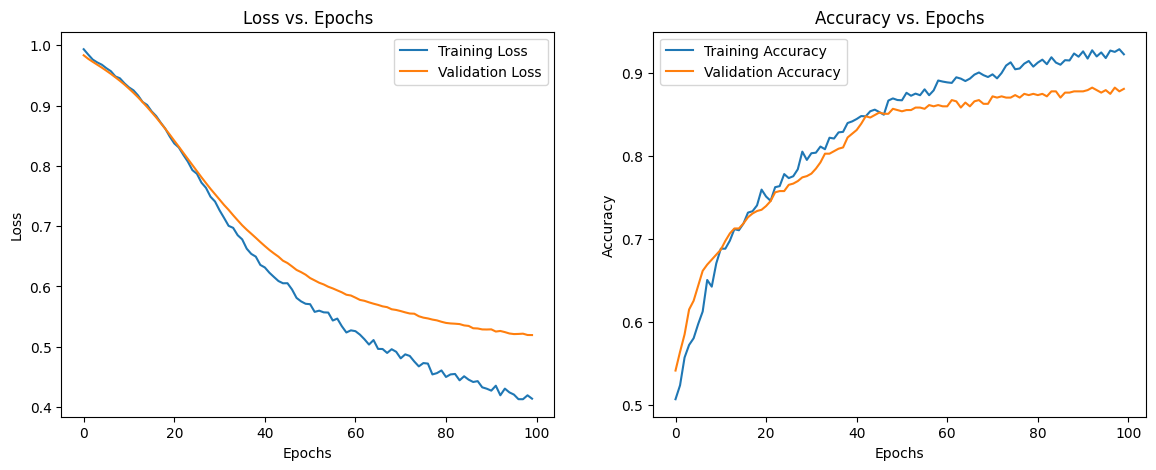

In [17]:
# Plot loss vs. epochs and accuracy vs. epochs
plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [2]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities for the test set
y_pred_prob = model.predict(X_test)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

NameError: name 'model' is not defined

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


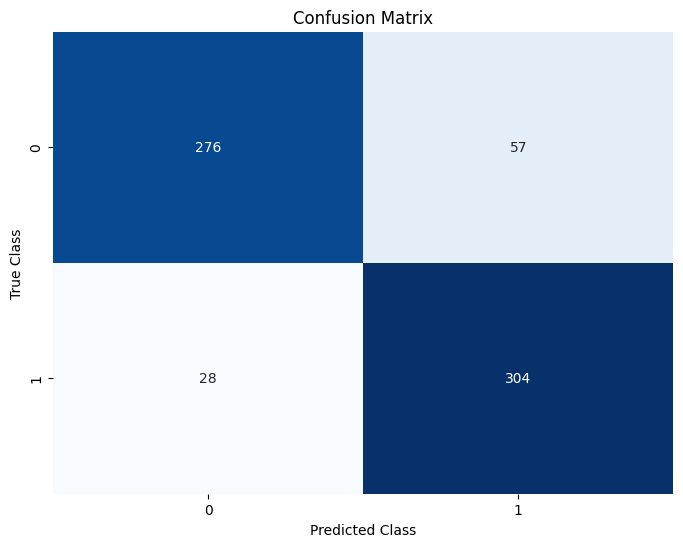

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.91      0.83      0.87       333
     Class 1       0.84      0.92      0.88       332

    accuracy                           0.87       665
   macro avg       0.88      0.87      0.87       665
weighted avg       0.88      0.87      0.87       665



In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict classes for the test set
y_pred_classes = (model.predict(X_test) > 0.5).astype(int)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Generate the classification report
class_report = classification_report(y_test, y_pred_classes, target_names=['Class 0', 'Class 1'])

# Print the classification report
print("Classification Report:")
print(class_report)

In [83]:
# Predict probabilities for the test set
y_pred_prob = model.predict(X_test)

# Convert probabilities to class predictions (0 or 1)
y_pred_classes = (y_pred_prob > 0.5).astype(int)

# Create a DataFrame to hold the results
results_df = pd.DataFrame({
    'Node 1': [edge[0] for edge in edge_info_test],
    'Node 2': [edge[1] for edge in edge_info_test],
    'Predicted Class': y_pred_classes.flatten(),
    'True Class': y_test
})

# Display the table
print(results_df)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
    Node 1 Node 2  Predicted Class  True Class
0      170     22                1           1
1        4     10                0           0
2       83     98                1           1
3      156     25                0           0
4      165    175                0           0
..     ...    ...              ...         ...
660     30     32                0           0
661     92      1                1           1
662    126    150                1           1
663    162    141                0           1
664      7    137                1           1

[665 rows x 4 columns]


# **Visualization**

**Static Visualization of the Network at a Specific Timestamp**
Objective: Visualize the network structure at a specific point in time.

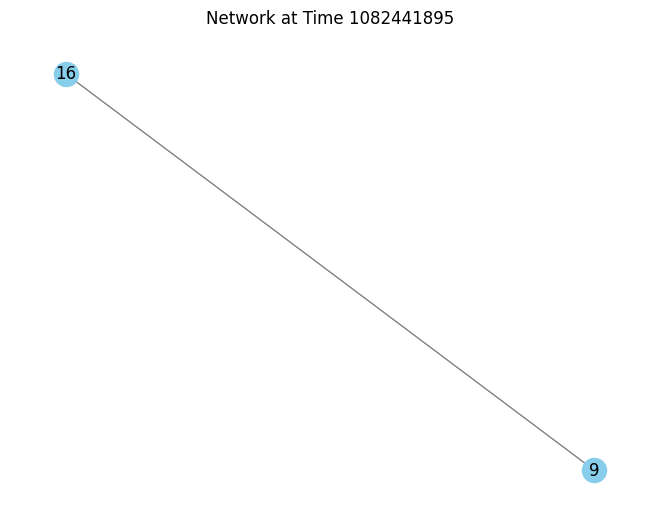

In [13]:
def plot_network_at_time(G, time):
    subgraph_edges = [(u, v) for u, v, d in G.edges(data=True) if d['time'] == time]
    subgraph = G.edge_subgraph(subgraph_edges)
    pos = nx.spring_layout(subgraph)
    nx.draw(subgraph, pos, with_labels=True, node_color='skyblue', edge_color='gray')
    plt.title(f"Network at Time {time}")
    plt.show()

# Example usage
plot_network_at_time(temporal_rw_sampler.temporal_network, time=1082441895)

**Temporal Heatmap** Objective: Show the intensity of connections over time.



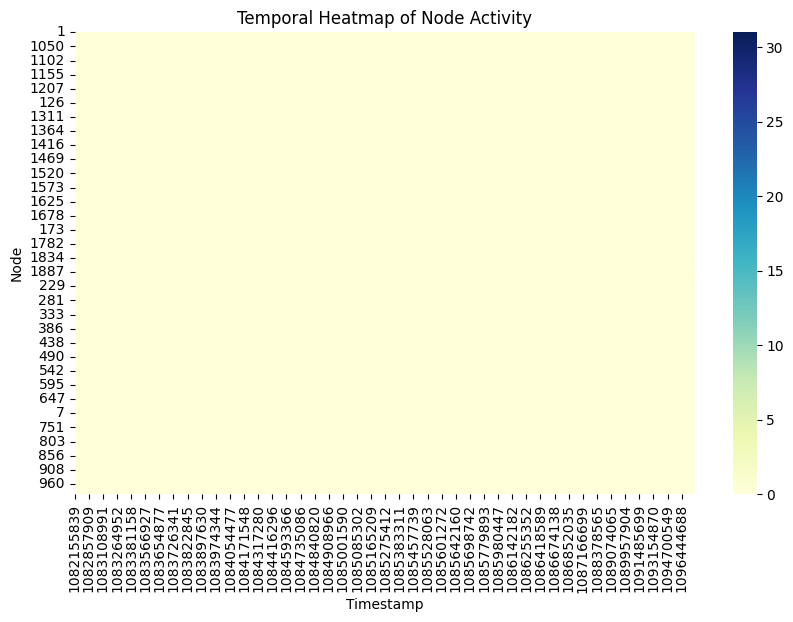

In [16]:
import seaborn as sns

# Check the density of the temporal network
num_edges = len(temporal_rw_sampler.temporal_network.edges())
num_possible_edges = len(temporal_rw_sampler.temporal_network.nodes()) ** 2
density = num_edges / num_possible_edges
print(f"Network density: {density:.4f}")

# Adjusting the heatmap plotting with a better color scale
plt.figure(figsize=(12, 8))
sns.heatmap(time_node_matrix, cmap="YlGnBu", vmin=0, vmax=np.percentile(time_node_matrix, 95))
plt.title("Temporal Heatmap of Node Activity")
plt.xlabel("Timestamp")
plt.ylabel("Node")
plt.show()

**Degree Evolution Over Time** Objective: Track how the degree (number of connections) of key nodes changes over time.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_node_correlation(temporal_network, time_steps):
    # Initialize an empty dictionary to keep track of the adjacency matrix over time
    adjacency_dict = {node: np.zeros(len(time_steps)) for node in temporal_network.nodes()}

    # Iterate over the time steps and populate the adjacency dictionary
    for t_idx, time in enumerate(time_steps):
        for u, v, d in temporal_network.edges(data=True):
            if d['time'] <= time:
                adjacency_dict[u][t_idx] += 1
                adjacency_dict[v][t_idx] += 1

    # Convert the adjacency dictionary to a DataFrame
    adjacency_df = pd.DataFrame.from_dict(adjacency_dict, orient='index')

    # Calculate the correlation matrix
    correlation_matrix = adjacency_df.corr()

    return correlation_matrix

# Example usage
time_steps = sorted(set(d['time'] for u, v, d in temporal_rw_sampler.temporal_network.edges(data=True)))
correlation_matrix = calculate_node_correlation(temporal_rw_sampler.temporal_network, time_steps)

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Node Correlation Heatmap')
plt.xlabel('Node')
plt.ylabel('Node')
plt.show()

**Community Detection and Visualization** Objective: Visualize communities within the temporal network and how they evolve.

/tmp/ipykernel_33/3079304364.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(communities))
/opt/conda/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


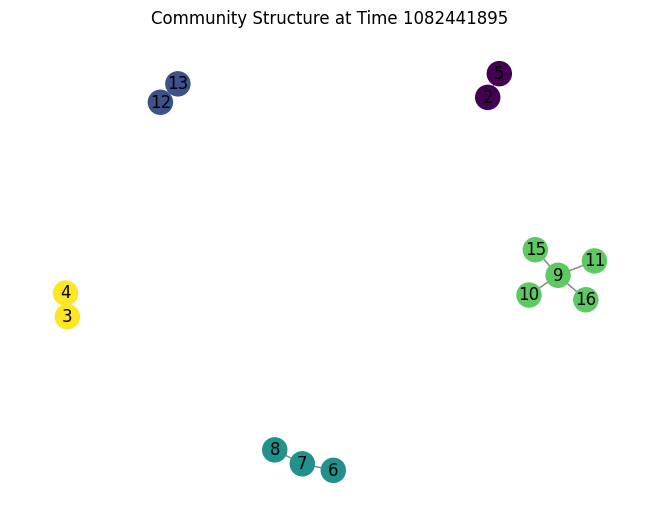

In [24]:
import community as community_louvain

def plot_communities_with_colors(G, time):
    # Create a subgraph for the specified time
    subgraph_edges = [(u, v) for u, v, d in G.edges(data=True) if d['time'] <= time]
    subgraph = G.edge_subgraph(subgraph_edges)
    
    # Compute the best partition (community detection)
    partition = community_louvain.best_partition(subgraph)
    
    # Get the unique community identifiers
    communities = list(set(partition.values()))
    
    # Assign a color to each community
    colors = plt.cm.get_cmap('viridis', len(communities))
    
    # Assign colors to nodes based on their community
    node_colors = [colors(partition[node]) for node in subgraph.nodes()]
    
    # Draw the network with the color-coded communities
    pos = nx.spring_layout(subgraph)
    nx.draw(subgraph, pos, node_color=node_colors, with_labels=True, node_size=300, edge_color='gray', cmap='viridis')
    
    # Add title
    plt.title(f"Community Structure at Time {time}")
    
    # Show the plot
    plt.show()

# Example usage
plot_communities_with_colors(temporal_rw_sampler.temporal_network, time=1082441895)

**Visualize the Frequency of Interactions**

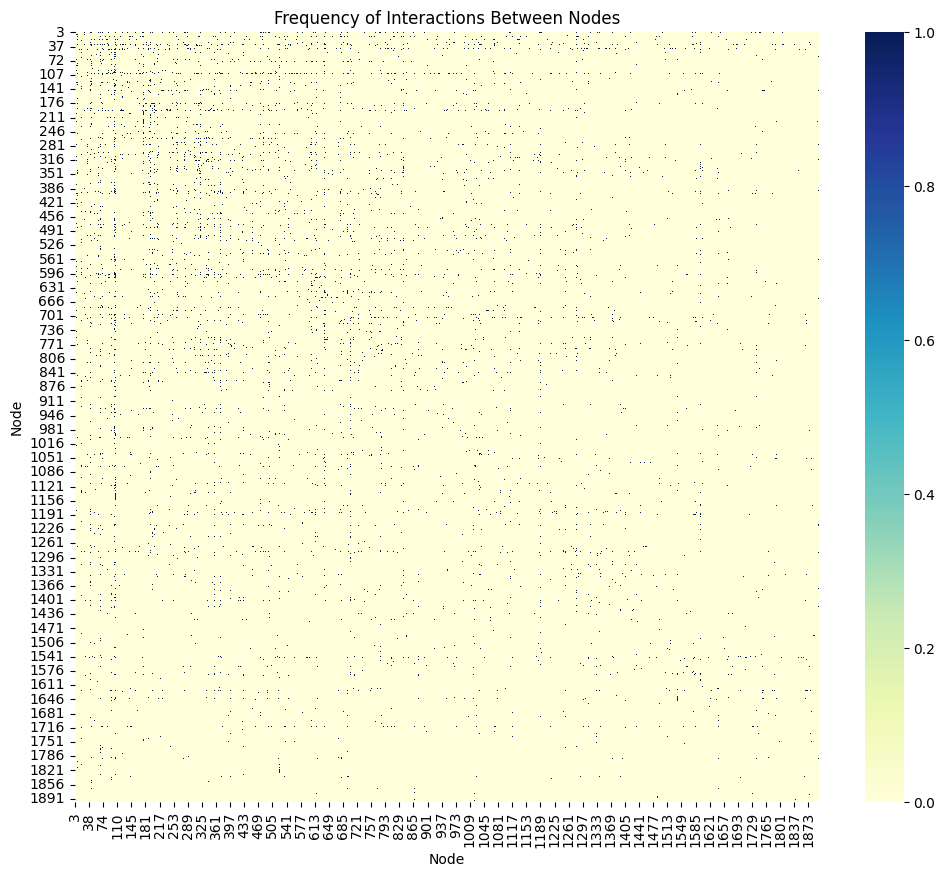

In [25]:
def plot_interaction_frequency(temporal_network):
    # Create an empty adjacency matrix to store the frequency of interactions
    nodes = list(temporal_network.nodes())
    adjacency_matrix = np.zeros((len(nodes), len(nodes)))

    # Fill the adjacency matrix with the frequency of interactions
    for u, v, d in temporal_network.edges(data=True):
        u_idx = nodes.index(u)
        v_idx = nodes.index(v)
        adjacency_matrix[u_idx, v_idx] += 1
        adjacency_matrix[v_idx, u_idx] += 1  # Assuming undirected graph

    # Convert the adjacency matrix to a DataFrame for easier visualization
    adjacency_df = pd.DataFrame(adjacency_matrix, index=nodes, columns=nodes)

    # Plot the heatmap of interaction frequencies
    plt.figure(figsize=(12, 10))
    sns.heatmap(adjacency_df, cmap='YlGnBu', annot=False)
    plt.title('Frequency of Interactions Between Nodes')
    plt.xlabel('Node')
    plt.ylabel('Node')
    plt.show()

# Example usage
plot_interaction_frequency(temporal_rw_sampler.temporal_network)

**Visualize the Frequencies of motifs in the walks**

In [26]:
def calculate_motif_frequencies(motifs):
    motif_frequencies = {}
    for size, size_motifs in motifs.items():
        motif_frequencies[size] = len(size_motifs)
    return motif_frequencies

In [27]:
def plot_motif_frequencies(motif_frequencies):
    sizes = list(motif_frequencies.keys())
    frequencies = list(motif_frequencies.values())

    plt.figure(figsize=(10, 6))
    plt.bar(sizes, frequencies, color='skyblue')
    plt.xlabel('Motif Size')
    plt.ylabel('Frequency')
    plt.title('Frequency of Motifs Over Walks')
    plt.xticks(sizes)
    plt.show()

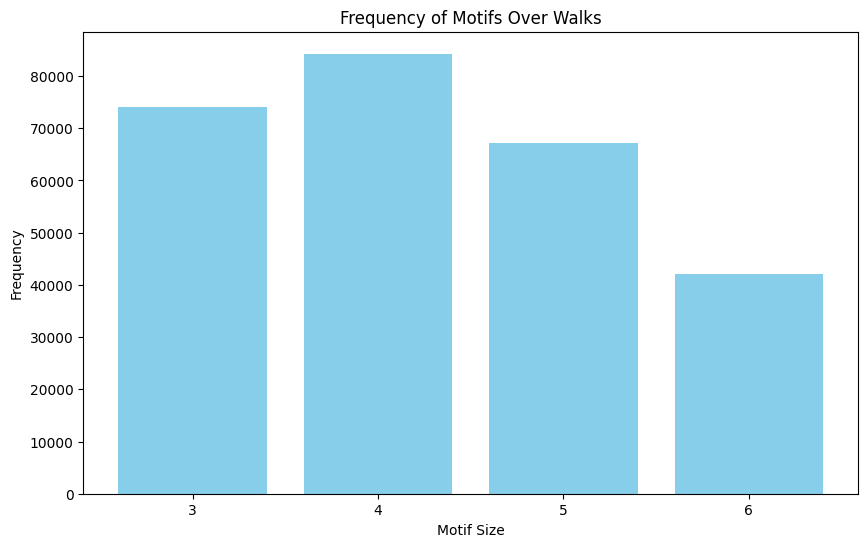

In [28]:
motif_frequencies = calculate_motif_frequencies(extracted_motifs)
plot_motif_frequencies(motif_frequencies)

In [29]:
def generate_walks_for_different_counts(sampler, walk_counts):
    all_walks_by_count = {}
    for count in walk_counts:
        sampler.num_walks = count
        node_sets = sampler.sample_temporal_random_walks()
        all_walks = [walk for walks in node_sets.values() for walk in walks]
        all_walks_by_count[count] = all_walks
    return all_walks_by_count

In [30]:
def extract_motifs_for_walk_counts(all_walks_by_count, motif_sizes):
    motifs_by_count = {}
    for count, walks in all_walks_by_count.items():
        motifs = extract_temporal_motifs(walks, motif_sizes)
        motifs_by_count[count] = motifs
    return motifs_by_count

In [31]:
def calculate_and_plot_frequencies(motifs_by_count):
    plt.figure(figsize=(15, 10))
    for count, motifs in motifs_by_count.items():
        motif_frequencies = calculate_motif_frequencies(motifs)
        sizes = list(motif_frequencies.keys())
        frequencies = list(motif_frequencies.values())

        plt.bar(sizes, frequencies, alpha=0.5, label=f'{count} Walks')

    plt.xlabel('Motif Size')
    plt.ylabel('Frequency')
    plt.title('Frequency of Motifs for Different Numbers of Walks')
    plt.xticks(sizes)
    plt.legend()
    plt.show()


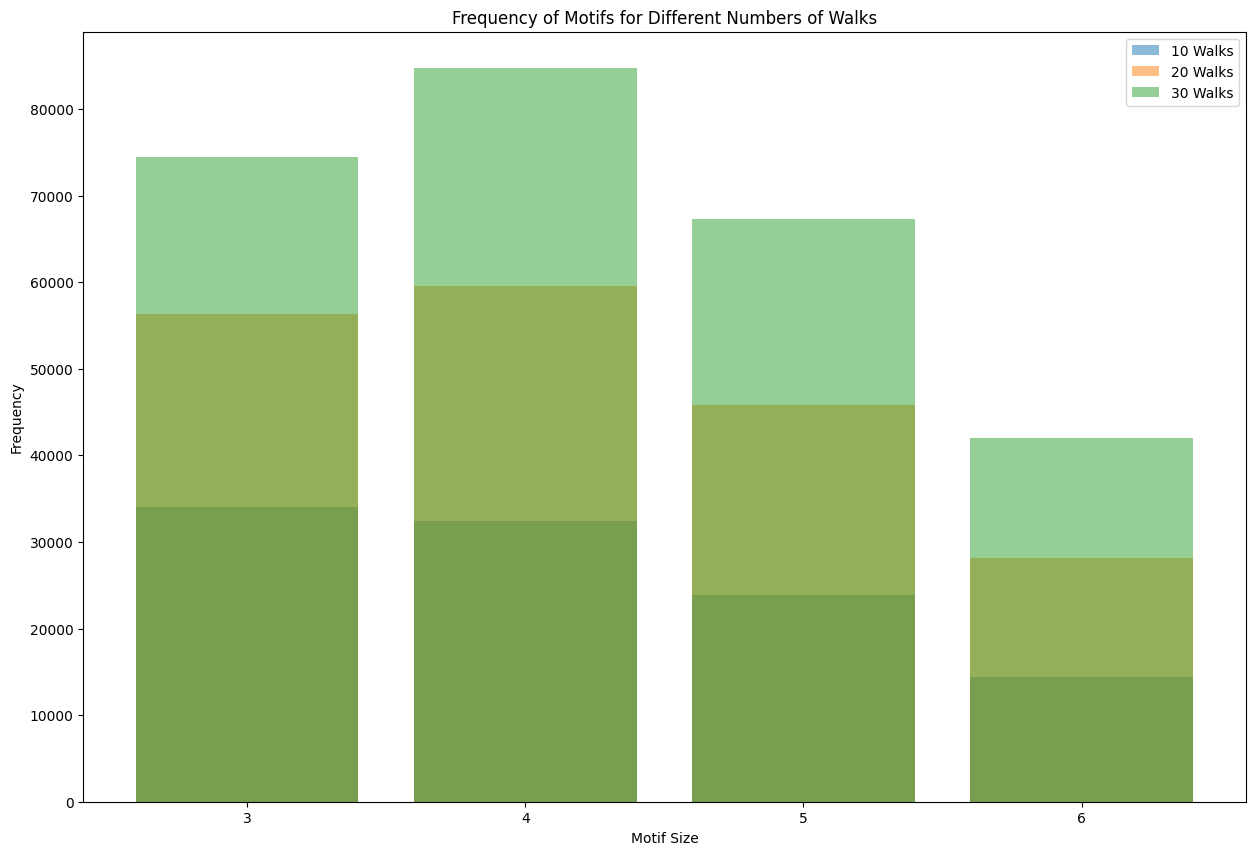

In [32]:
# Example usage:
walk_counts = [10, 20, 30]
motif_sizes = [3, 4, 5, 6]

# Assuming you have an instance of your sampler
all_walks_by_count = generate_walks_for_different_counts(temporal_rw_sampler, walk_counts)
motifs_by_count = extract_motifs_for_walk_counts(all_walks_by_count, motif_sizes)
calculate_and_plot_frequencies(motifs_by_count)